In [109]:
import os
import torch
import torchaudio
import numpy as np
from tqdm import tqdm
from transformers import WhisperProcessor, WhisperModel
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.utils.class_weight import compute_class_weight
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score,f1_score,confusion_matrix
import random
# Paths and settings


In [38]:
ROOT_DIR = r"C:\Users\Raihan\OneDrive\Desktop\OPEN_PROJECT_AUDIO\data\train_dataset"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Load Whisper
processor = WhisperProcessor.from_pretrained("openai/whisper-base")
model = WhisperModel.from_pretrained("openai/whisper-base").encoder.to(DEVICE)


# RAVDESS Emotion Code to Label Map



In [39]:
model.eval()

# RAVDESS emotion code to label mapping
emotion_map = {
    '01': 0,  # neutral
    '02': 1,  # calm
    '03': 2,  # happy
    '04': 3,  # sad
    '05': 4,  # angry
    '06': 5,  # fearful
    '07': 6,  # disgust
    '08': 7,  # surprised
}

features = []
labels = []

with torch.no_grad():
    for root, _, files in os.walk(ROOT_DIR):
        for file in tqdm(files, desc="Processing"):
            if not file.endswith(".wav"):
                continue
            path = os.path.join(root, file)

            # Extract emotion label from RAVDESS filename
            parts = file.split("-")
            if len(parts) < 3:
                continue
            emotion_code = parts[2]
            if emotion_code not in emotion_map:
                continue
            label = emotion_map[emotion_code]

            # Load audio
            waveform, sr = torchaudio.load(path)
            if sr != 16000:
                waveform = torchaudio.functional.resample(waveform, sr, 16000)
            waveform = waveform.mean(dim=0)  # convert to mono

            # Whisper preprocessing
            inputs = processor(waveform.numpy(), sampling_rate=16000, return_tensors="pt")
            input_features = inputs["input_features"].to(DEVICE)

            # Encoder forward pass
            outputs = model(input_features)
            last_hidden_state = outputs.last_hidden_state  # (1, seq_len, 512)
            pooled = last_hidden_state.mean(dim=1)  # mean pooling

            features.append(pooled.squeeze(0).cpu().numpy())
            labels.append(label)

Processing:   0%|          | 0/2452 [00:00<?, ?it/s]

Processing: 100%|██████████| 2452/2452 [31:09<00:00,  1.31it/s] 


In [116]:
class ImprovedWhisperMLP(nn.Module):
    def __init__(self, input_dim=512, num_classes=8):
        super(ImprovedWhisperMLP, self).__init__()

        self.net = nn.Sequential(
            nn.LayerNorm(input_dim),                     # Normalize input
            nn.Linear(input_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.4),

            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.ReLU(),

            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.net(x)

In [117]:
def seed_all(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

seed_all()

In [119]:
X=features
print(type(X))
y=labels
X_train, X_val, y_train, y_val = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

<class 'list'>


In [120]:
class WhisperDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [121]:
train_dataset=WhisperDataset(X_train,y_train)
val_dataset=WhisperDataset(X_val,y_val)
train_loader=DataLoader(train_dataset,batch_size=32,shuffle=True)
val_loader=DataLoader(val_dataset,batch_size=32)

In [122]:
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(DEVICE)

In [123]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ImprovedWhisperMLP().to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1,weight=class_weights)

In [124]:
model=ImprovedWhisperMLP()
optimizer= optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler=ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)

In [134]:
best_acc = 0
for epoch in range(1, 91):
    model.train()
    train_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation
    model.eval()
    val_preds, val_labels = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            out = model(xb)
            pred = torch.argmax(out, dim=1).cpu().numpy()
            val_preds.extend(pred)
            val_labels.extend(yb.numpy())

    val_acc = accuracy_score(val_labels, val_preds)
    f1=f1_score(val_labels,val_preds,average="macro")
    cm=confusion_matrix(val_labels,val_preds)
    scheduler.step(val_acc)
    print(cm)
    print(f"Epoch {epoch} | Train Loss: {train_loss/len(train_loader):.4f} | Val Acc: {val_acc:.4f}|F1 Score:{f1:.4f}")

[[35  0  2  1  0  0  0  0]
 [ 1 68  2  3  0  0  1  0]
 [ 4  1 62  1  1  3  2  1]
 [ 2  7  0 59  0  6  1  0]
 [ 0  0  0  1 71  0  2  1]
 [ 0  0  1  9  2 63  0  0]
 [ 0  0  1  0  0  0 36  2]
 [ 0  0  0  0  0  0  0 39]]
Epoch 1 | Train Loss: 0.6246 | Val Acc: 0.8819|F1 Score:0.8856
[[35  2  1  0  0  0  0  0]
 [ 1 69  1  3  0  0  1  0]
 [ 4  2 59  1  1  5  2  1]
 [ 3  8  0 59  0  5  0  0]
 [ 0  0  0  1 71  0  2  1]
 [ 0  0  1  8  2 64  0  0]
 [ 0  0  1  0  0  0 36  2]
 [ 0  0  0  0  0  0  0 39]]
Epoch 2 | Train Loss: 0.6246 | Val Acc: 0.8798|F1 Score:0.8837
[[34  0  2  1  0  1  0  0]
 [ 1 68  2  3  0  0  1  0]
 [ 5  0 60  1  1  5  2  1]
 [ 2  6  0 57  0  9  1  0]
 [ 0  0  0  1 71  0  2  1]
 [ 0  0  1  7  2 65  0  0]
 [ 0  0  1  0  0  0 36  2]
 [ 0  0  0  0  0  0  0 39]]
Epoch 3 | Train Loss: 0.6402 | Val Acc: 0.8758|F1 Score:0.8790
[[35  0  2  1  0  0  0  0]
 [ 1 69  1  3  0  0  1  0]
 [ 4  1 61  1  1  4  2  1]
 [ 3  7  0 56  0  8  1  0]
 [ 0  0  0  1 71  0  2  1]
 [ 0  0  1  6  2 66  0  0

In [135]:
print("Accuracy")
print(val_acc)
print("F1 score")
print(f1)
print("Confusion Matrix")
print(cm)



Accuracy
0.8859470468431772
F1 score
0.8896451683519052
Confusion Matrix
[[35  1  2  0  0  0  0  0]
 [ 1 69  1  3  0  0  1  0]
 [ 4  1 63  1  1  2  2  1]
 [ 2  8  0 60  0  5  0  0]
 [ 0  0  0  1 71  0  2  1]
 [ 0  1  1  9  2 62  0  0]
 [ 0  0  1  0  0  0 36  2]
 [ 0  0  0  0  0  0  0 39]]


In [136]:
per_class_acc = cm.diagonal() / cm.sum(axis=1)

# Print nicely
for i, acc in enumerate(per_class_acc):
    print(f"Class {i} Accuracy: {acc:.4f}")

Class 0 Accuracy: 0.9211
Class 1 Accuracy: 0.9200
Class 2 Accuracy: 0.8400
Class 3 Accuracy: 0.8000
Class 4 Accuracy: 0.9467
Class 5 Accuracy: 0.8267
Class 6 Accuracy: 0.9231
Class 7 Accuracy: 1.0000


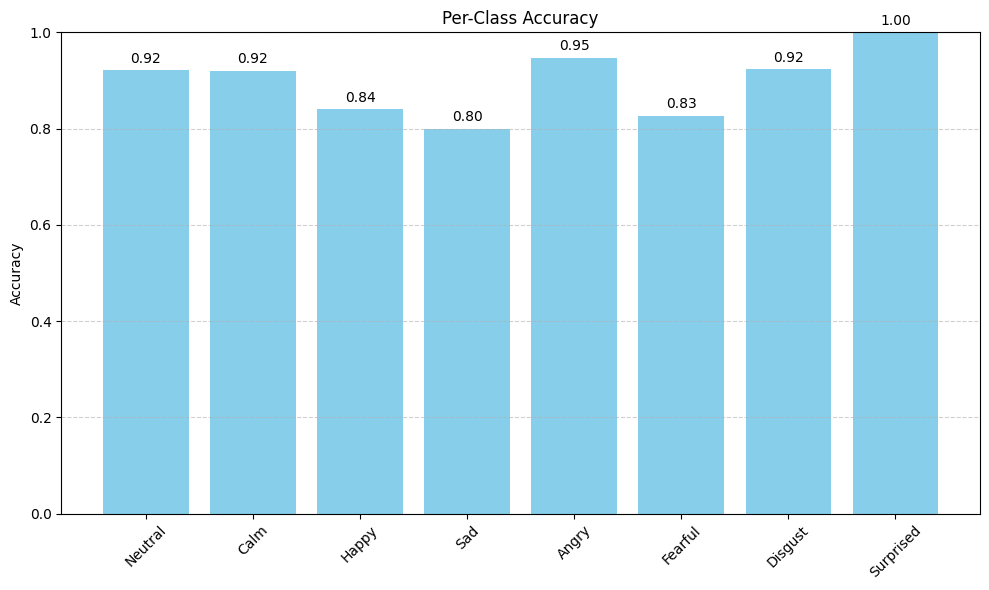

In [137]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming these are your predictions and ground truths
y_true = val_labels  # true labels
y_pred = val_preds   # predicted labels

# Optional: Replace with your actual emotion labels
class_names = ["Neutral", "Calm", "Happy", "Sad", "Angry", "Fearful", "Disgust", "Surprised"]

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Compute per-class accuracy
per_class_acc = cm.diagonal() / cm.sum(axis=1)

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.bar(class_names, per_class_acc, color='skyblue')
plt.ylim([0, 1])
plt.ylabel("Accuracy")
plt.title("Per-Class Accuracy")

# Annotate bars
for bar, acc in zip(bars, per_class_acc):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f"{acc:.2f}", ha='center', va='bottom')

plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [138]:
torch.save(model.state_dict(), "whisper_model.pth")
print("✅ Model weights saved to whisper_model.pth")

✅ Model weights saved to whisper_model.pth
